# Qubit-Efficient Quantum State Preparation

In this notebook, we provide a circuit-level implementation that prepares an arbitrary quantum state with arbitrary complex-valued amplitudes.

See https://github.com/guikaiwen/qubit_efficient_QSP/blob/main/QSP_Method_Call_Demo.ipynb for a simple method call walk-through.

## Overall Structure

Our goal is to prepare the wave function state vector

$$U_{\mathrm{QSP}} |0^n\rangle = |\psi\rangle = \frac{1}{\lVert \mathbf{x}\rVert}\sum_{i=0}^{2^{n-1}}x_i |i\rangle, x_i \in \mathbb{C}$$

via sequence of multi-control Ry and multi-control Rz gates, using the method described in Chapter 4.2 of Schuld et al.'s QML textbook (https://link.springer.com/book/10.1007/978-3-030-83098-4). The protocol was originally proposed in Mottonen et al. 2004 (https://arxiv.org/pdf/quant-ph/0407010.pdf).

(Note that $N = 2^n$)

In other words, we can prepare an arbitrary $n$-qubit quantum state (with complex amplitudes) from an $n$-qubit product state. 

We can visualize the $U_{\mathrm{QSP}}$ circuit using the circuit diagram below (the inverse of the circuit in the QML textbook):

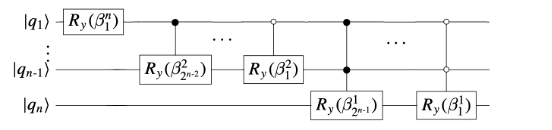

This operation has the following circuit complexity numbers:
    
A. $O(N)$ depth using generalized multi-controlled Ry gates

B. No additional ancilla qubits required (total of $O(\log(N))$ qubits)

Note that this circuit can only create states for which all amplitudes are positive real numbers. To also include negative real amplitudes and complex coefficients, we need to add additional multi-control Rz gates, which fortunately does not change the overall $O(N)$ circuit complexity.

In [1]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

import numpy as np
import random
import math

from helper_functions import *

## Circuit Implementation

### Classical Part - Compute Angles

We first classically compute the amplitude rotation angles $\beta$ for the Ry rotations using Eq. 4.30 from the QML textbook (page 156 in 2nd edition):

$\beta_j^s = 2\,\text{arcsin}\Bigg(\frac{\sqrt{\sum_{l=0}^{2^{s-1} - 1}|a_{(2j-1)2^{s-1}+l}|^2}}{\sqrt{\sum_{l=0}^{2^{s}-1}|a_{(j-1)2^{s}+l}|^2}}\Bigg)$

These $\beta$ angles are needed for the multi-control Ry gates, as it exactly appeared in the circuit diagram above.

(Note that the book uses 1-indexing, whereas a python array data structure has 0-indexing. Therefore the $l$ values are shifted down by 1 in the implementation below.)

The letter $a$ is the amplitude of each basis. You can get it by calling `np.abs` on the complex number coefficient, as shown later in the `qsp_qubit_eff` function.

Other than $s$ and $j$ parameters, this function also requires the entire input wave function vector array to define the particular rotation angles. In practice, one could also utilize the tree structure to get a square root speed up on this part.

In [2]:
def compute_ry_rotation_angle(s: int, j: int, amplitude_array: np.ndarray) -> float:
    """
    Function to compute a particular beta_{s,j} angle according to the equation above
    
    @param s: as it appear in equation 4.30 in the ML with QC book
    @param j: as it appear in equation 4.30 in the ML with QC book
    @param WF_array: the entire wave function array vector amplitude values to be encoded
    
    @return: a float/double value that holds the computed angle 
    """
    sum_top = 0.0
    for l in range(0, 2 ** (s - 1) - 1 + 1): # compute the sum on the numerator
        current_var = amplitude_array[(2 * j - 1) * 2 ** (s - 1) + l]
        sum_top += current_var ** 2
    
    sum_bottom = 0.0
    for l in range(0, 2 ** s - 1 + 1): # compute the sum on the denominator
        current_var = amplitude_array[(j - 1) * 2 ** s + l]
        sum_bottom += current_var ** 2
        
    if sum_bottom == 0: # edge case: arcsin denominator is zero
        return 0.0
    else:
        return 2 * np.arcsin(np.sqrt(sum_top) / np.sqrt(sum_bottom))

If our coefficients $x_i$ are complex number, we need to compute the phase rotation angles $\alpha$ for the Rz rotations, using Eq. 5 from Mottonen et al. 2004 (note that the index $s$ is replaced with $k$ to maintain consistency with the QML textbook). This is not covered in the QML textbook.

$\alpha_j^s = \frac{\sum_{l=0}^{2^{s-1}-1}(\omega_{(2j - 1)2^{s-1}+l} - \omega_{(2j - 2)2^{s-1}+l})}{2^{s-1}}$

These angles are needed for the multi-control Rz gates.

(Note that the paper uses 1-indexing, whereas a python array data structure has 0-indexing. Therefore the $l$ values are shifted down by 1 in the implementation below.)

The letter $\omega$ is the phase of each basis. You can get it by calling `np.angle` on the complex number coefficient, as shown later in the `qsp_qubit_eff` function.

In [3]:
def compute_rz_rotation_angle(s: int, j: int, phase_array: np.ndarray) -> float:
    """
    Function to compute a particular beta_{s,j} angle according to the equation above
    
    @param s: as it appear in equation 4.30 in the ML with QC book
    @param j: as it appear in equation 4.30 in the ML with QC book
    @param phase_array: the entire wave function array vector phase values to be encoded
    
    @return: a float/double value that holds the computed phase angle
    """
    sum_top = 0.0
    for l in range(0, 2 ** (s - 1) - 1 + 1): # compute the sum on the numerator
        current_var = phase_array[(2 * j - 1) * 2 ** (s - 1) + l] - phase_array[(2 * j - 2) * 2 ** (s - 1) + l]
        sum_top += current_var
    
    return sum_top / (2 ** (s - 1))

### Quantum Part

#### Define Multi-Control and Multi-Anticontrol Ry gates

Now let's construct the multi-control rotation gates.


An easy way to define the open/close controlness is to use the binary representation. A binary 0 would mean an open control; a binary 1 would mean a close control.

(Note that the most natural way of representing the open control as binary number is to use 0-indexing. Therefore the converted $j$ values are shifted down by 1.)

We will need to "sandwich" the C-Ry gates with the corresponding x gates in order to realize the open control operations, as illustrated in the figure below.

Whenever there is an X gate before and after the control, this would indicate switching from close control (conditioned on 1) to open control (conditioned on 0):

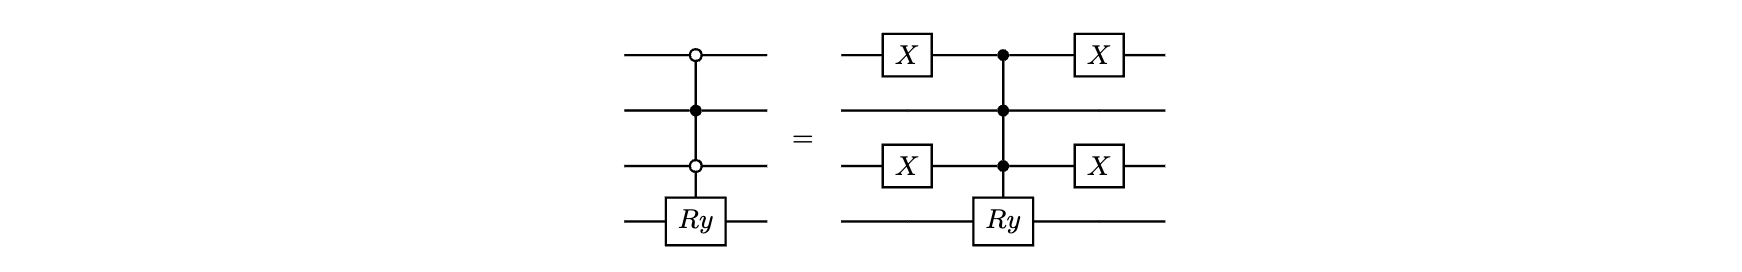


In [4]:
def x_gate_sequence(s: int, j: int, n: int, circ: braket.circuits.circuit.Circuit):
    """
    Function to add x gates to help emulate the anti-control operations
    
    @param s: as it appear in the equation above
    @param j: as it appear in the equation above
    n: total number of qubits for the state being prepared
    circ: quantum circuit to operate on
    """
    binary_j = bin(j - 1).replace("0b", "").zfill(n - s) # get the binary representation of the current j
    for i in range(n - s):
        if int(binary_j[i]) == 0:
            circ.x(i)

Now let's merge the x gate sequence and the buildin multi-control Ry gate together to form a full multi-control rotation gate, depending on the particular $s$, $j$ values (which offers the $\beta_j^s$ and $\alpha_j^s$ values for the rotation angles, and the entire wave function vector array (here we divide into `amplitude_array` to hold the real values and `phase_array` to hold the complex angles):

In [5]:
def full_multi_control_rotation_gate(s: int, j: int, n: int, circ: braket.circuits.circuit.Circuit, amplitude_array: np.ndarray, phase_array: np.ndarray, tolerance = 1e-10):
    """
    Function to perform a full multi-control rotation gate based on the s and j values, will anti-control conditions included

    @param s: as it appear in equation 4.30 in the ML with QC book
    @param j: as it appear in equation 4.30 in the ML with QC book
    @param n: total number of qubits for the state being prepared
    @param circ: quantum circuit to operate on
    @param WF_array: the entire wave function array vector values to be encoded 
    """
    ry_rotation_angle = compute_ry_rotation_angle(s, j, amplitude_array)
    rz_rotation_angle = compute_rz_rotation_angle(s, j, phase_array)
    target_bit_index = n - s
    control_qubit_list = list(range(target_bit_index)) # get the control qubit list
    
    if np.abs(ry_rotation_angle) > tolerance or np.abs(rz_rotation_angle) > tolerance: # the tolerance are set to eliminate the rotation gates when the rotation angle is very close to zero
        x_gate_sequence(s, j, n, circ) # insert x gate if anti-control
    if np.abs(ry_rotation_angle) > tolerance:
        circ.ry(angle=ry_rotation_angle, target=target_bit_index, control=control_qubit_list)
    if np.abs(rz_rotation_angle) > tolerance:
        circ.rz(angle=rz_rotation_angle, target=target_bit_index, control=control_qubit_list)
    if np.abs(ry_rotation_angle) > tolerance or np.abs(rz_rotation_angle) > tolerance:
        x_gate_sequence(s, j, n, circ) # insert x gate if anti-control

#### Call Implemented Gate Function to Form QSP Circuit

With the full multi-control rotation gate defined, we can now construct the whole QSP circuit using the circuit:

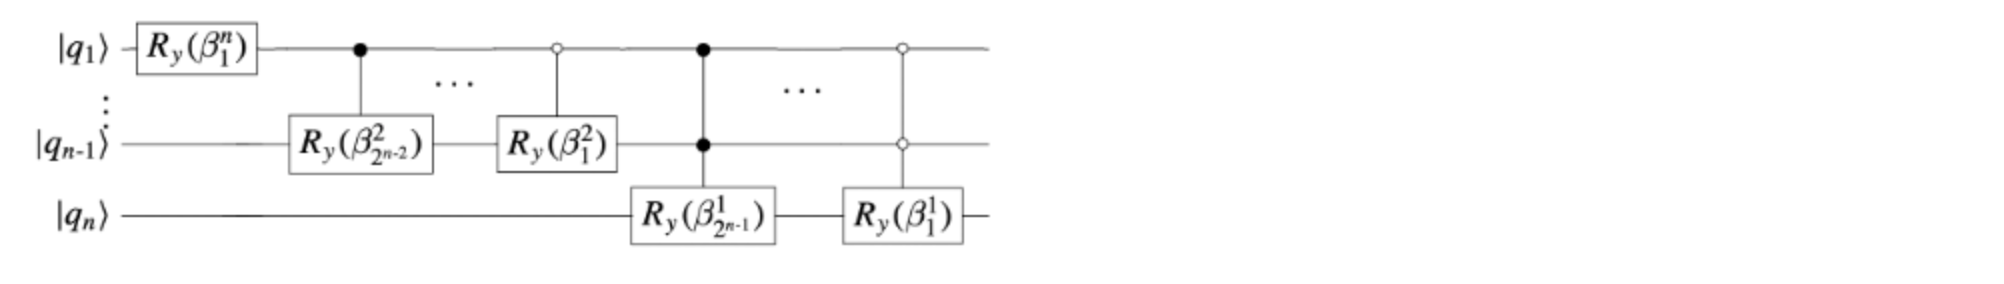

We can create a nested for loop. The outer layer loops over the lower index $s$ (in descending order starting with $s=n$), where after each iteration, a state on $n-s+1$ qubits has been created. The inner layer loops over the upper index $j$ (which iterates through all $2^{n-s}$ multi-control rotation gates acting on this particular qubit), as shown below.

In [6]:
def qsp_qubit_eff(normalized_complex_array: np.ndarray) -> braket.circuits.circuit.Circuit:
    """
    Function to construct the full QSP circuit using the full multi-control rotation gate
    
    @param WF_array: the array of amplitudes to be encoded into the state vector (wave function)
    
    @return circ: the constructed quantum circuit
    """
    amplitude_array = np.abs(normalized_complex_array) # get the a values as shown above
    phase_array = np.angle(normalized_complex_array) # get the \omega values as shown above
    
    array_len = len(normalized_complex_array)
    assert array_len > 0 and (array_len & (array_len - 1)) == 0 , "wave function array needs to have length as power of 2, consider padding it with zeros"
    l2_norm = np.linalg.norm(normalized_complex_array, ord=2)
    assert abs(l2_norm - 1) < 1e-10, "wave function array needs to be normalized"
    
    circ = Circuit()
    
    n = int(math.log2(len(normalized_complex_array)))
    for s in range(n, 0, -1): # as it exactly defined in the figure above
            for j in range(2 ** (n - s), 0, -1):
                full_multi_control_rotation_gate(s, j, n, circ, amplitude_array, phase_array)
    return circ

#### Classically Generate Random State Vector Array

In order to define the QSP circuit, we would first need to specify the target state vector $|\psi\rangle$ we want to get, expressed in the 1D-array form $[x_0, x_1, ..., x_{2^n - 1}]$.

Let's generate a random normalized state vector array of size $2^3 = 8$ using the helper functions.

You can change `n` to a larger `int` number and see what happens for states on a larger number of qubits!

We will display the vector values in a column with all values rounded to 3 digits, using the helper functions.

In [7]:
def generate_normalized_complex_array(n: int) -> np.ndarray:
    """
    Function to generate a normalized random complex-valued vector
    
    @param n: total number of data qubits
    
    @return normalized_v: an array of size 2^n that holds the generated nomalized complex vector
    """
    array_length = 2 ** n
    # Generate a complex array with random complex values that may contain negatives
    complex_array = (np.random.rand(array_length) - 0.5) + 1j * (np.random.rand(array_length) - 0.5)

    # Normalize the complex array
    normalized_complex_array = complex_array / np.linalg.norm(complex_array)

    return normalized_complex_array

In [8]:
%%time
np.random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
n = 3 # number of qubits. We can encode 2^n number of values with n qubits!
normalized_complex_array = generate_normalized_complex_array(n)
print(row_to_column_vector(round_to_three_significant_digits(normalized_complex_array, 3)))

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]
CPU times: user 369 µs, sys: 67 µs, total: 436 µs
Wall time: 429 µs


#### Construct QSP Circuit

With all components prepared, we can call the default circuit construction methods to act on an empty Braket circuit, using the same `qsp_qubit_eff` function. Notice that there is another layer of multi-control Rz gate added on top of the multi-control Ry gate to pump in the phase values.

In [9]:
initialized_circ = qsp_qubit_eff(normalized_complex_array)
print(initialized_circ)

T  : |   0    |   1    |   2    |   3    |4|   5    |   6    |7|   8    |    9    |10|   11   |   12   |13|   14   |   15   |16|17|   18   |   19    |20|
                                                                                                                                                         
q0 : -Ry(1.36)-Rz(1.39)-C--------C--------X-C--------C--------X-C--------C------------C--------C--------X--C--------C--------X--X--C--------C---------X--
                        |        |          |        |          |        |            |        |           |        |              |        |            
q1 : -------------------Ry(1.48)-Rz(0.61)---Ry(1.28)-Rz(2.67)---C--------C---------X--C--------C--------X--C--------C--------X-----C--------C---------X--
                                                                |        |            |        |           |        |              |        |            
q2 : -----------------------------------------------------------Ry(1.16)-Rz(

<span style="color:orange;">We also note that to decompose a general n-qubit control-Ry gate, one would need to use single qubit + CNOT gates with $O(n)$ depth. Therefore, we would naively need $O(n2^n)$ depth using single qubit + CNOT gates. Sun et al. 2021 was able to improve the depth to $O(2^n/n)$. </span>

## Algorithm Demo - Circuit Execution

Now let's test our constructed circuit!

We execute the constructed circuit using the Braket's local simulator.

In [10]:
%%time
braket_device = LocalSimulator() # define the simulator
initialized_circ.state_vector() # convert the circuit to state vector
braket_state_vector_result = braket_device.run(initialized_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_state_vector_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.109-0.333j]
 [-0.488-0.172j]
 [ 0.157+0.102j]
 [ 0.324+0.272j]
 [-0.148-0.378j]
 [-0.206+0.091j]
 [-0.137+0.328j]
 [ 0.232+0.008j]]
CPU times: user 38.8 ms, sys: 2.06 ms, total: 40.9 ms
Wall time: 41.7 ms


Notice that the circuit state vector output looks very different from the generated vector input. Why is this the case? This is because we have a global phase difference! In other words, instead of having the exact state $|\psi\rangle$, we instead have $e^{i\theta}|\psi\rangle$. This additional global phase does not carry any physical meaning, nor does it affect the final measurement results on the real quantum computer.

We can perform the test below to see if circuit state vector result is the same as the input vector but only with a global phase difference. For the circuit state vector result $|\psi'\rangle = e^{i\theta}|\psi\rangle$ and input vector $|\psi\rangle$, we should expect $|\langle\psi'|\psi\rangle| = 1$

In [11]:
print(np.abs(np.dot(normalized_complex_array, np.conj(braket_state_vector_result))))

1.0000000000000002


We can also try to compute the phase difference $\theta_i$ between each pair of basis:

In [12]:
phase_v1 = np.angle(normalized_complex_array)
phase_v2 = np.angle(braket_state_vector_result)

# Compute the global phase difference between v1 and v2
global_phase_difference = phase_v1 - phase_v2
global_phase_difference = (global_phase_difference + np.pi) % (2 * np.pi) - np.pi
print(global_phase_difference)

[0.37114178 0.37114178 0.37114178 0.37114178 0.37114178 0.37114178
 0.37114178 0.37114178]


You can see that all the phase differences are the same across all values (and thus a global phase)!

Now we can add the phase correction to the circuit state vector output:

In [13]:
global_phase_corrected_braket_state_vector_result = braket_state_vector_result * np.exp(1j * global_phase_difference[0])
print(row_to_column_vector(round_to_three_significant_digits(global_phase_corrected_braket_state_vector_result, 3)))

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]


#### Compare Diff

In [14]:
print(row_to_column_vector(global_phase_corrected_braket_state_vector_result - normalized_complex_array))

[[-2.77555756e-17-5.55111512e-17j]
 [ 1.11022302e-16+0.00000000e+00j]
 [ 6.93889390e-17+1.11022302e-16j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.75133952e-17-1.66533454e-16j]
 [-8.32667268e-17+2.42861287e-17j]
 [-5.55111512e-17-5.55111512e-17j]
 [ 0.00000000e+00+1.38777878e-17j]]


The result matches perfectly with the desired output!

In [15]:
import braket._sdk as braket_sdk
braket_sdk.__version__

'1.55.0'

In [16]:
import sys
print(sys.version)

3.10.11 (main, May 17 2023, 14:30:36) [Clang 14.0.6 ]
